## Question 1

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from numba import njit
from copy import deepcopy

In [2]:
# Sigmoid
phi = lambda v: 1/(1+np.exp(-v))
# Derivative of sigmoid
dphi = lambda v: np.multiply(phi(v), (1-phi(v)))

# Initialize random weights given shape of NN
def init(shape):
    weights = []
    for i in range(len(shape)-1):
        w = np.mat(np.random.rand(shape[i]+1, shape[i+1])*2-1)
        weights.append(w)
    return weights

# Predict y value given x and NN weights
# If performing backprop, then return the delta weights and prediction error
def pred(weights, x, y=0, backprop=False):
    x_out = x
    Xs, Vs = [], [] # Keep track of Vs and Xs to be used in backprop
    # Forward pass
    for i in range(len(weights)):
        x_out = np.mat(np.insert(x_out,0,1))
        Xs.append(x_out)
        v = x_out.dot(weights[i])
        Vs.append(v)
        x_out = phi(v)
    if not backprop: return x_out
    
    # Backpropagate
    # Output delta rule
    err = (y - x_out)
    delta = err * dphi(Vs[-1])
    d_weights = [np.mat(delta * Xs[-1]).T]
    # Generalized delta rule
    for i in range(len(weights)-1, 0, -1):
        delta = np.multiply(delta.dot(weights[i].T), np.insert(dphi(Vs[i-1]),0,1))
        d_weights.insert(0, delta.T[1:].dot(Xs[i-1]).T)
    return d_weights, float(err)

# Given initialized NN, train on given X,Y data
# If epochs='inf', run until max absolute error is < 0.5
# Return array of recorded MSE for each epoch
def fit(weights, X, Y, eta=0.5, alpha=0, epochs=float('inf')):
    epoch, all_mse, max_abs_err = 0, [], float('inf')
    prev_d_weights = None
    while (epoch < epochs) and (max_abs_err > 0.05):
        epoch, mse, max_abs_err = epoch+1, 0, 0
        avg_d_weights = None
        
        # Single epoch, iterating over all data points
        for x,y in zip(X,Y):
            # Predict for given data point, recording results of backpropagation
            d_weights, err = pred(weights, x, y, backprop=True)
            # Update average weights
            if avg_d_weights is None: avg_d_weights = d_weights
            else:
                for i in range(len(weights)):
                    avg_d_weights[i] += d_weights[i]
            # Update MSE and max_abs_error
            mse += err**2
            if abs(err) > max_abs_err: max_abs_err = abs(err)

        # Update weights given the epoch's average delta weights
        if prev_d_weights is None: prev_d_weights = [0] * len(weights)
        for i in range(len(weights)):
            weights[i] += eta * avg_d_weights[i] / len(weights) + alpha * prev_d_weights[i] / len(weights)
        prev_d_weights = deepcopy(avg_d_weights)
        
        mse /= len(X)
        all_mse.append(mse)
        if epoch in np.geomspace(1000, 1000000, 30, endpoint=True).astype('int'):
            print("  epoch {}/{}, MSE: {}, Max Error: {}".format(epoch, epochs, mse, max_abs_err))
    return all_mse

In [3]:
# Create data (4-bit XOR problem)
X = np.mat([list(format(n, '#06b')[2:]) for n in range(16)], dtype=int)
Y = np.mat([np.sum(x)%2 for x in X]).T

Training NN using eta = 0.5
  epoch 1000/1000000, MSE: 0.2499746206616672, Max Error: 0.5101257109234063
  epoch 1268/1000000, MSE: 0.24994478389769706, Max Error: 0.5103588362737367
  epoch 1610/1000000, MSE: 0.2498726128032881, Max Error: 0.5126874042837595
  epoch 2043/1000000, MSE: 0.24949647384755216, Max Error: 0.5243326144564637
  epoch 2592/1000000, MSE: 0.22356948741725732, Max Error: 0.590602718796006
  epoch 3290/1000000, MSE: 0.06679195265289131, Max Error: 0.8319289050693432
  epoch 4175/1000000, MSE: 0.05539230223823339, Max Error: 0.8258656028477122
  epoch 5298/1000000, MSE: 0.052874649604691695, Max Error: 0.816444132060906
  epoch 6723/1000000, MSE: 0.051802429990746586, Max Error: 0.8110761940481395
  epoch 8531/1000000, MSE: 0.05122073483120729, Max Error: 0.807815850411723
  epoch 10826/1000000, MSE: 0.0508639916640498, Max Error: 0.805688006940728
  epoch 13738/1000000, MSE: 0.05062882510558532, Max Error: 0.8042262365446275
  epoch 17433/1000000, MSE: 0.050466278

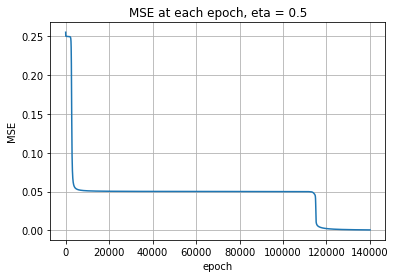

Training NN using eta = 0.45
  epoch 1000/1000000, MSE: 0.1721287605959606, Max Error: 0.7641196711962136
  epoch 1268/1000000, MSE: 0.11890334642631126, Max Error: 0.8420511442130122
  epoch 1610/1000000, MSE: 0.10912752007819573, Max Error: 0.8319125218170202
  epoch 2043/1000000, MSE: 0.09962510188988996, Max Error: 0.8396787593671724
  epoch 2592/1000000, MSE: 0.0593486627628164, Max Error: 0.8104870793719189
  epoch 3290/1000000, MSE: 0.052146322811746575, Max Error: 0.78825521035186
  epoch 4175/1000000, MSE: 0.020595614908780615, Max Error: 0.40834913653166754
  epoch 5298/1000000, MSE: 0.0022231232184617596, Max Error: 0.09794262766238059
  epoch 6723/1000000, MSE: 0.0010441750243597675, Max Error: 0.059046531272093604
  Solution found after 7532 epochs
  Proof of solution:
[[0 0 0 0]] [[0]] [[0.02816452]]
[[0 0 0 1]] [[1]] [[0.97180157]]
[[0 0 1 0]] [[1]] [[0.96456446]]
[[0 0 1 1]] [[0]] [[0.02083874]]
[[0 1 0 0]] [[1]] [[0.97181425]]
[[0 1 0 1]] [[0]] [[0.03720671]]
[[0 1 1 0

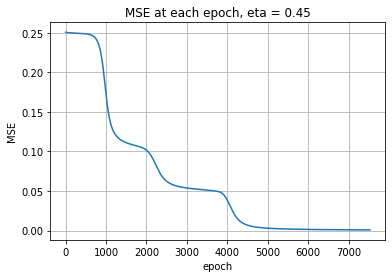

Training NN using eta = 0.4
  epoch 1000/1000000, MSE: 0.24992304849462246, Max Error: 0.5064580115775511
  epoch 1268/1000000, MSE: 0.24988727108929734, Max Error: 0.506321480602779
  epoch 1610/1000000, MSE: 0.24981520399753623, Max Error: 0.5083368521786682
  epoch 2043/1000000, MSE: 0.2495946138158211, Max Error: 0.5157562534419018
  epoch 2592/1000000, MSE: 0.24730651987486618, Max Error: 0.5497649688581041
  epoch 3290/1000000, MSE: 0.11525184983884239, Max Error: 0.8233677036318241
  epoch 4175/1000000, MSE: 0.06468962608303196, Max Error: 0.8688166378034574
  epoch 5298/1000000, MSE: 0.05671478425568202, Max Error: 0.8351141390050718
  epoch 6723/1000000, MSE: 0.05376962008203838, Max Error: 0.8212199713086842
  epoch 8531/1000000, MSE: 0.05238106633148719, Max Error: 0.8141880006889959
  epoch 10826/1000000, MSE: 0.051611469981790475, Max Error: 0.8100253622862469
  epoch 13738/1000000, MSE: 0.05113880663081252, Max Error: 0.8073288408524096
  epoch 17433/1000000, MSE: 0.05082

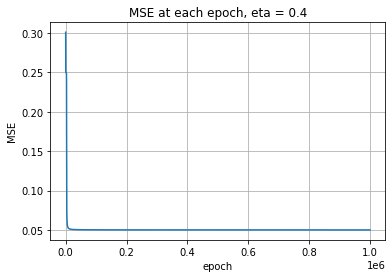

Training NN using eta = 0.35
  epoch 1000/1000000, MSE: 0.24963576965352657, Max Error: 0.5126365789568252
  epoch 1268/1000000, MSE: 0.24912888074572345, Max Error: 0.5218643114805316
  epoch 1610/1000000, MSE: 0.24477968009405313, Max Error: 0.5560371746447238
  epoch 2043/1000000, MSE: 0.1561879877889011, Max Error: 0.7044674209791285
  epoch 2592/1000000, MSE: 0.07477208987232666, Max Error: 0.8325302842453041
  epoch 3290/1000000, MSE: 0.060263522930447386, Max Error: 0.8331028989514986
  epoch 4175/1000000, MSE: 0.054422405434181274, Max Error: 0.8064892612857394
  epoch 5298/1000000, MSE: 0.014672533630305639, Max Error: 0.33978659751824286
  epoch 6723/1000000, MSE: 0.0025336145260090068, Max Error: 0.11129987692092273
  epoch 8531/1000000, MSE: 0.0011990853973257315, Max Error: 0.0693014211352053
  epoch 10826/1000000, MSE: 0.000716039469503161, Max Error: 0.05066855481746951
  Solution found after 10954 epochs
  Proof of solution:
[[0 0 0 0]] [[0]] [[0.02353968]]
[[0 0 0 1]] 

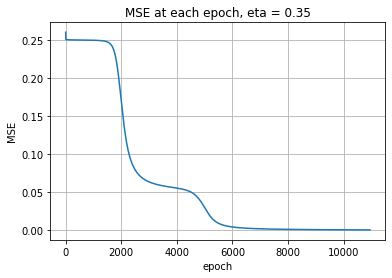

Training NN using eta = 0.3
  epoch 1000/1000000, MSE: 0.2483778811959463, Max Error: 0.5350315596167121
  epoch 1268/1000000, MSE: 0.24382573200274468, Max Error: 0.5732189015732988
  epoch 1610/1000000, MSE: 0.2020129710307466, Max Error: 0.5980670964620542
  epoch 2043/1000000, MSE: 0.11834792800798541, Max Error: 0.8069644781068359
  epoch 2592/1000000, MSE: 0.07956494166068875, Max Error: 0.8400102003741882
  epoch 3290/1000000, MSE: 0.06288829352198681, Max Error: 0.8244988904879371
  epoch 4175/1000000, MSE: 0.05556426538888366, Max Error: 0.793156251904522
  epoch 5298/1000000, MSE: 0.05079384863236682, Max Error: 0.7531464429468653
  epoch 6723/1000000, MSE: 0.047407003388092624, Max Error: 0.719303412627273
  epoch 8531/1000000, MSE: 0.04531263719714119, Max Error: 0.6984436891792845
  epoch 10826/1000000, MSE: 0.04408868544803534, Max Error: 0.6868274854130613
  epoch 13738/1000000, MSE: 0.04334926997902424, Max Error: 0.6801695624647814
  epoch 17433/1000000, MSE: 0.0428763

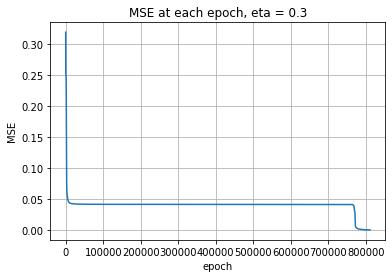

Training NN using eta = 0.25
  epoch 1000/1000000, MSE: 0.25001542539616256, Max Error: 0.5062204272815761
  epoch 1268/1000000, MSE: 0.25000629350146675, Max Error: 0.504708990204176
  epoch 1610/1000000, MSE: 0.24999926423865734, Max Error: 0.5034245521472619
  epoch 2043/1000000, MSE: 0.24999351332667596, Max Error: 0.5024237620851536
  epoch 2592/1000000, MSE: 0.24998766970149386, Max Error: 0.5026383131508064
  epoch 3290/1000000, MSE: 0.24997900001369094, Max Error: 0.5038266301032386
  epoch 4175/1000000, MSE: 0.24995946052601623, Max Error: 0.505271692316658
  epoch 5298/1000000, MSE: 0.24988795451845128, Max Error: 0.5078348755796152
  epoch 6723/1000000, MSE: 0.24902270105245272, Max Error: 0.5201240290041079
  epoch 8531/1000000, MSE: 0.08018490180914181, Max Error: 0.8014395870280425
  epoch 10826/1000000, MSE: 0.05490170615829705, Max Error: 0.8166452833678172
  epoch 13738/1000000, MSE: 0.05225796393653506, Max Error: 0.8101791666841012
  epoch 17433/1000000, MSE: 0.05134

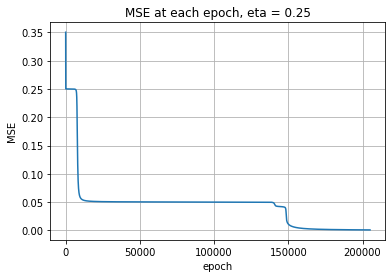

Training NN using eta = 0.2
  epoch 1000/1000000, MSE: 0.25008981066930747, Max Error: 0.5147826651093217
  epoch 1268/1000000, MSE: 0.2500602787275336, Max Error: 0.5120575588086757
  epoch 1610/1000000, MSE: 0.250038147974516, Max Error: 0.5097473838071701
  epoch 2043/1000000, MSE: 0.2500212393071988, Max Error: 0.5079139349430288
  epoch 2592/1000000, MSE: 0.25000703592035556, Max Error: 0.506599200258896
  epoch 3290/1000000, MSE: 0.24999237910882993, Max Error: 0.505870378823237
  epoch 4175/1000000, MSE: 0.24997141879887963, Max Error: 0.50586458501581
  epoch 5298/1000000, MSE: 0.24992569624156613, Max Error: 0.5069604455350739
  epoch 6723/1000000, MSE: 0.2497360024008983, Max Error: 0.5175665979879392
  epoch 8531/1000000, MSE: 0.23745661421031614, Max Error: 0.6063586658598207
  epoch 10826/1000000, MSE: 0.07032918848030315, Max Error: 0.8861690738869331
  epoch 13738/1000000, MSE: 0.055464513396890756, Max Error: 0.8327354833540035
  epoch 17433/1000000, MSE: 0.052555811935

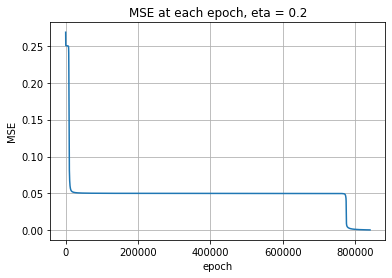

Training NN using eta = 0.15
  epoch 1000/1000000, MSE: 0.24741815344345733, Max Error: 0.5292055693314957
  epoch 1268/1000000, MSE: 0.24461837993578592, Max Error: 0.5540634617177435
  epoch 1610/1000000, MSE: 0.23522628550449975, Max Error: 0.5905998991049968
  epoch 2043/1000000, MSE: 0.20241801583318142, Max Error: 0.5951617909446529
  epoch 2592/1000000, MSE: 0.14071645688689094, Max Error: 0.7883488021741565
  epoch 3290/1000000, MSE: 0.09093929584854285, Max Error: 0.8560477356222391
  epoch 4175/1000000, MSE: 0.07222365321579546, Max Error: 0.8706726209210084
  epoch 5298/1000000, MSE: 0.06401884794488044, Max Error: 0.8606451050446459
  epoch 6723/1000000, MSE: 0.0594697129958673, Max Error: 0.8463855994856497
  epoch 8531/1000000, MSE: 0.05661317274175999, Max Error: 0.8347524768356006
  epoch 10826/1000000, MSE: 0.0547136667738203, Max Error: 0.825972242725072
  epoch 13738/1000000, MSE: 0.05341035921165773, Max Error: 0.8194422545793842
  epoch 17433/1000000, MSE: 0.052495

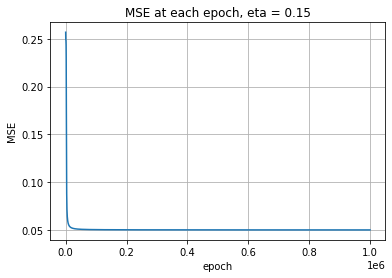

Training NN using eta = 0.1
  epoch 1000/1000000, MSE: 0.25009878526805657, Max Error: 0.5192526705618632
  epoch 1268/1000000, MSE: 0.2500698240076519, Max Error: 0.5165446682517202
  epoch 1610/1000000, MSE: 0.25004593111127393, Max Error: 0.5139524788968513
  epoch 2043/1000000, MSE: 0.2500274001848374, Max Error: 0.5116201791174856
  epoch 2592/1000000, MSE: 0.25001346533244423, Max Error: 0.5096597707474468
  epoch 3290/1000000, MSE: 0.25000268711847773, Max Error: 0.5081630571599497
  epoch 4175/1000000, MSE: 0.2499931498322974, Max Error: 0.5071925418496867
  epoch 5298/1000000, MSE: 0.24998225423513357, Max Error: 0.5067652919734946
  epoch 6723/1000000, MSE: 0.24996524730292266, Max Error: 0.5075960352090685
  epoch 8531/1000000, MSE: 0.24992651575794445, Max Error: 0.5103518315568812
  epoch 10826/1000000, MSE: 0.2497583746462074, Max Error: 0.5183862574010968
  epoch 13738/1000000, MSE: 0.24263579507429242, Max Error: 0.5931060133745288
  epoch 17433/1000000, MSE: 0.10940960

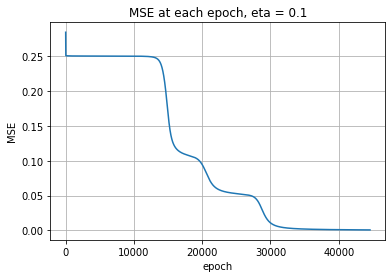

Training NN using eta = 0.05
  epoch 1000/1000000, MSE: 0.25049339334652926, Max Error: 0.5448504251848403
  epoch 1268/1000000, MSE: 0.25036282966411066, Max Error: 0.5378938575147818
  epoch 1610/1000000, MSE: 0.2502562893558785, Max Error: 0.5311057299303467
  epoch 2043/1000000, MSE: 0.25017506911516374, Max Error: 0.5248113354801605
  epoch 2592/1000000, MSE: 0.25011619009376274, Max Error: 0.5192512578600108
  epoch 3290/1000000, MSE: 0.25007478316893544, Max Error: 0.5146192564793365
  epoch 4175/1000000, MSE: 0.2500456857589927, Max Error: 0.5110492052221979
  epoch 5298/1000000, MSE: 0.2500243497073724, Max Error: 0.5085389668798146
  epoch 6723/1000000, MSE: 0.25000759868529654, Max Error: 0.5069849083593081
  epoch 8531/1000000, MSE: 0.24999302737201665, Max Error: 0.5062492113684842
  epoch 10826/1000000, MSE: 0.2499774522898306, Max Error: 0.5062924680634372
  epoch 13738/1000000, MSE: 0.24995320967692491, Max Error: 0.5073936415144975
  epoch 17433/1000000, MSE: 0.2498909

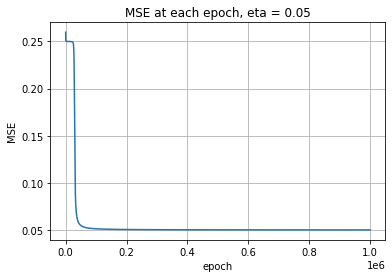

In [4]:
# Train NN for varying eta values
# No momentum (alpha=0)
for eta in [x/100 for x in range(50, 0, -5)]:
    print("Training NN using eta = {}".format(eta))   
    # Initialize NN
    shape = [4, 4, 1]
    weights = init(shape)
    all_mse = fit(weights, X, Y, eta, epochs=1000000)

    print("  Solution found after {} epochs".format(len(all_mse)))
    print("  Proof of solution:")
    for x,y in zip(X,Y):
        print(x, y, pred(weights, x))

    # Plot MSE
    x = np.arange(0, len(all_mse), 1)
    y = np.array(all_mse)
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel='epoch', ylabel='MSE',
       title='MSE at each epoch, eta = {}'.format(eta))
    ax.grid()

    plt.show()

Training NN using eta = 0.5
  epoch 1000/1000000, MSE: 0.2498765892435414, Max Error: 0.5188759646286273
  epoch 1268/1000000, MSE: 0.24794940517816985, Max Error: 0.5696763611462677
  epoch 1610/1000000, MSE: 0.0917046218782667, Max Error: 0.8529040310051316
  epoch 2043/1000000, MSE: 0.049624823569599456, Max Error: 0.7408327247520253
  epoch 2592/1000000, MSE: 0.003334755765961419, Max Error: 0.13323501353242545
  epoch 3290/1000000, MSE: 0.0008735344611377963, Max Error: 0.05482819149672619
  Solution found after 3443 epochs
  Proof of solution:
[[0 0 0 0]] [[0]] [[0.02512203]]
[[0 0 0 1]] [[1]] [[0.96445263]]
[[0 0 1 0]] [[1]] [[0.97344843]]
[[0 0 1 1]] [[0]] [[0.0193177]]
[[0 1 0 0]] [[1]] [[0.97384489]]
[[0 1 0 1]] [[0]] [[0.02263433]]
[[0 1 1 0]] [[0]] [[0.03329129]]
[[0 1 1 1]] [[1]] [[0.98307993]]
[[1 0 0 0]] [[1]] [[0.96445145]]
[[1 0 0 1]] [[0]] [[0.04995688]]
[[1 0 1 0]] [[0]] [[0.01935219]]
[[1 0 1 1]] [[1]] [[0.97450553]]
[[1 1 0 0]] [[0]] [[0.02268346]]
[[1 1 0 1]] [[1]

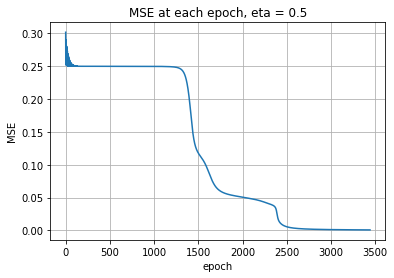

Training NN using eta = 0.45
  epoch 1000/1000000, MSE: 0.06026486043004035, Max Error: 0.8461144032718717
  epoch 1268/1000000, MSE: 0.054351680067858586, Max Error: 0.8221336460351105
  epoch 1610/1000000, MSE: 0.052443565962911685, Max Error: 0.8132694161008562
  epoch 2043/1000000, MSE: 0.051554018208698746, Max Error: 0.8088183121511514
  epoch 2592/1000000, MSE: 0.051056386762532865, Max Error: 0.8061966028782311
  epoch 3290/1000000, MSE: 0.050747351168863516, Max Error: 0.804502497762602
  epoch 4175/1000000, MSE: 0.05054324376000221, Max Error: 0.8033465495195375
  epoch 5298/1000000, MSE: 0.050402251370978465, Max Error: 0.8025255647796203
  epoch 6723/1000000, MSE: 0.05030180224534155, Max Error: 0.801926228797349
  epoch 8531/1000000, MSE: 0.050228614976473865, Max Error: 0.8014798948437678
  epoch 10826/1000000, MSE: 0.05017436397878287, Max Error: 0.8011423486438789
  epoch 13738/1000000, MSE: 0.050133647658002524, Max Error: 0.800884217035194
  epoch 17433/1000000, MSE: 

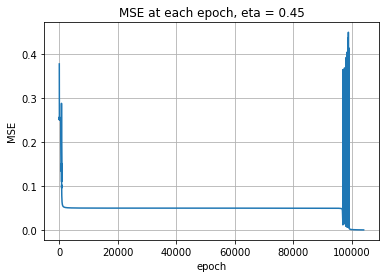

Training NN using eta = 0.4
  epoch 1000/1000000, MSE: 0.16142601639396695, Max Error: 0.7801188581823655
  epoch 1268/1000000, MSE: 0.10820217132298372, Max Error: 0.8402730880218919
  epoch 1610/1000000, MSE: 0.06137166949130007, Max Error: 0.8206033438534062
  epoch 2043/1000000, MSE: 0.023215273884983546, Max Error: 0.437326600004994
  epoch 2592/1000000, MSE: 0.00186078016475742, Max Error: 0.09042922950085241
  epoch 3290/1000000, MSE: 0.0008204989272070401, Max Error: 0.053563539671782845
  Solution found after 3437 epochs
  Proof of solution:
[[0 0 0 0]] [[0]] [[0.02464472]]
[[0 0 0 1]] [[1]] [[0.9766167]]
[[0 0 1 0]] [[1]] [[0.96628395]]
[[0 0 1 1]] [[0]] [[0.02091701]]
[[0 1 0 0]] [[1]] [[0.97661737]]
[[0 1 0 1]] [[0]] [[0.03303025]]
[[0 1 1 0]] [[0]] [[0.02078061]]
[[0 1 1 1]] [[1]] [[0.9835393]]
[[1 0 0 0]] [[1]] [[0.9766367]]
[[1 0 0 1]] [[0]] [[0.03302739]]
[[1 0 1 0]] [[0]] [[0.0211237]]
[[1 0 1 1]] [[1]] [[0.98354528]]
[[1 1 0 0]] [[0]] [[0.03302737]]
[[1 1 0 1]] [[1]] 

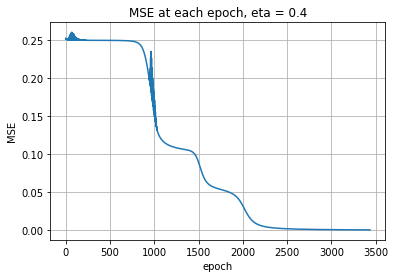

Training NN using eta = 0.35
  epoch 1000/1000000, MSE: 0.05563983321441385, Max Error: 0.7858942387424929
  epoch 1268/1000000, MSE: 0.04830256202554189, Max Error: 0.7286044746906711
  epoch 1610/1000000, MSE: 0.042720426438760936, Max Error: 0.6507582476320956
  epoch 2043/1000000, MSE: 0.03809717436316639, Max Error: 0.5856979276748536
  epoch 2592/1000000, MSE: 0.03533790852551935, Max Error: 0.5494924847685869
  epoch 3290/1000000, MSE: 0.0338196167905329, Max Error: 0.5303524449758811
  epoch 4175/1000000, MSE: 0.0329459819306684, Max Error: 0.51960380964072
  epoch 5298/1000000, MSE: 0.032403402177176334, Max Error: 0.5130349825570598
  epoch 6723/1000000, MSE: 0.03202340623928558, Max Error: 0.5084163852356474
  epoch 8531/1000000, MSE: 0.03144111470357715, Max Error: 0.5006138362591888
  Solution found after 10065 epochs
  Proof of solution:
[[0 0 0 0]] [[0]] [[0.01956186]]
[[0 0 0 1]] [[1]] [[0.96863809]]
[[0 0 1 0]] [[1]] [[0.98998988]]
[[0 0 1 1]] [[0]] [[0.03454915]]
[[0 

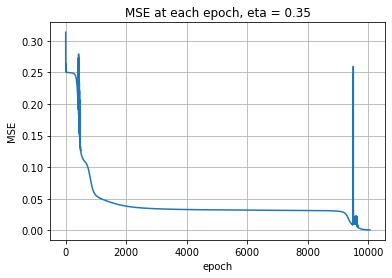

Training NN using eta = 0.3
  epoch 1000/1000000, MSE: 0.055956373251608196, Max Error: 0.8184487574190116
  epoch 1268/1000000, MSE: 0.05367052119483764, Max Error: 0.8143171863511691
  epoch 1610/1000000, MSE: 0.052459713513647796, Max Error: 0.8109229918529642
  epoch 2043/1000000, MSE: 0.05173411157815981, Max Error: 0.808376457567133
  epoch 2592/1000000, MSE: 0.05126114586520205, Max Error: 0.8064596562188701
  epoch 3290/1000000, MSE: 0.0509351892466689, Max Error: 0.8049983088389285
  epoch 4175/1000000, MSE: 0.05070293703247889, Max Error: 0.80387589369984
  epoch 5298/1000000, MSE: 0.05053295130793621, Max Error: 0.8030044549735573
  epoch 6723/1000000, MSE: 0.05040612606931802, Max Error: 0.8023209488855646
  epoch 8531/1000000, MSE: 0.050309988592515335, Max Error: 0.801777457587252
  epoch 10826/1000000, MSE: 0.05023581183463091, Max Error: 0.8013334499694621
  epoch 13738/1000000, MSE: 0.0501767311776489, Max Error: 0.8009428995731726
  epoch 17433/1000000, MSE: 0.0501230

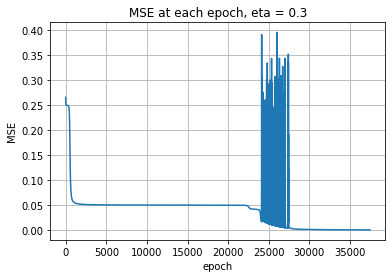

Training NN using eta = 0.25
  epoch 1000/1000000, MSE: 0.24999154086562533, Max Error: 0.507280267596323
  epoch 1268/1000000, MSE: 0.24998687381213566, Max Error: 0.5075188266614439
  epoch 1610/1000000, MSE: 0.24997591249719214, Max Error: 0.5090651431952342
  epoch 2043/1000000, MSE: 0.24992179961649744, Max Error: 0.5149416680257426
  epoch 2592/1000000, MSE: 0.22702375359351173, Max Error: 0.6545024965230778
  epoch 3290/1000000, MSE: 0.05906815347781359, Max Error: 0.8266326512835753
  epoch 4175/1000000, MSE: 0.0029044982696811777, Max Error: 0.11980615290576624
  epoch 5298/1000000, MSE: 0.0007515870040527442, Max Error: 0.0507774628892409
  Solution found after 5337 epochs
  Proof of solution:
[[0 0 0 0]] [[0]] [[0.02418731]]
[[0 0 0 1]] [[1]] [[0.97859145]]
[[0 0 1 0]] [[1]] [[0.95958664]]
[[0 0 1 1]] [[0]] [[0.02022173]]
[[0 1 0 0]] [[1]] [[0.97861169]]
[[0 1 0 1]] [[0]] [[0.03319795]]
[[0 1 1 0]] [[0]] [[0.02011114]]
[[0 1 1 1]] [[1]] [[0.98537199]]
[[1 0 0 0]] [[1]] [[0.9

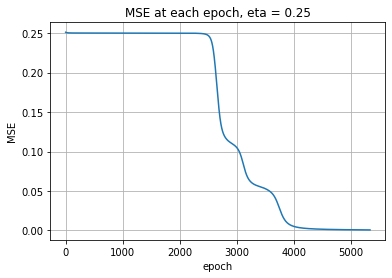

Training NN using eta = 0.2
  epoch 1000/1000000, MSE: 0.2499722987709191, Max Error: 0.5032282283390966
  epoch 1268/1000000, MSE: 0.2499114475620938, Max Error: 0.5074900376783682
  epoch 1610/1000000, MSE: 0.24892146961511186, Max Error: 0.5357993097332208
  epoch 2043/1000000, MSE: 0.07616488296970728, Max Error: 0.8376460741541271
  epoch 2592/1000000, MSE: 0.03589508516691783, Max Error: 0.5555747738707493
  epoch 3290/1000000, MSE: 0.0023313667575547738, Max Error: 0.09309790704216847
  epoch 4175/1000000, MSE: 0.000942010407269439, Max Error: 0.053425531257497716
  Solution found after 4346 epochs
  Proof of solution:
[[0 0 0 0]] [[0]] [[0.0173427]]
[[0 0 0 1]] [[1]] [[0.97159512]]
[[0 0 1 0]] [[1]] [[0.97901845]]
[[0 0 1 1]] [[0]] [[0.01696162]]
[[0 1 0 0]] [[1]] [[0.97159763]]
[[0 1 0 1]] [[0]] [[0.04810481]]
[[0 1 1 0]] [[0]] [[0.01703944]]
[[0 1 1 1]] [[1]] [[0.97517385]]
[[1 0 0 0]] [[1]] [[0.97544112]]
[[1 0 0 1]] [[0]] [[0.03473708]]
[[1 0 1 0]] [[0]] [[0.02159805]]
[[1 

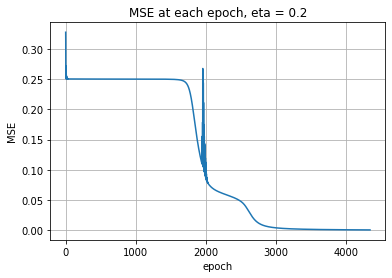

Training NN using eta = 0.15
  epoch 1000/1000000, MSE: 0.24997519584529593, Max Error: 0.5085287113887713
  epoch 1268/1000000, MSE: 0.249910410286432, Max Error: 0.5164714428965408
  epoch 1610/1000000, MSE: 0.2497246033635376, Max Error: 0.5758518546139846
  epoch 2043/1000000, MSE: 0.13744736240751107, Max Error: 0.6272957592766527
  epoch 2592/1000000, MSE: 0.05758487505198518, Max Error: 0.8307050935344334
  epoch 3290/1000000, MSE: 0.05307534583441361, Max Error: 0.8171228634293063
  epoch 4175/1000000, MSE: 0.0517431474705306, Max Error: 0.810617814980663
  epoch 5298/1000000, MSE: 0.05112135378118374, Max Error: 0.8071507144127089
  epoch 6723/1000000, MSE: 0.05077014830095751, Max Error: 0.8050585494575107
  epoch 8531/1000000, MSE: 0.05055007354459768, Max Error: 0.8036912009390607
  epoch 10826/1000000, MSE: 0.05040295910827066, Max Error: 0.8027489269524999
  epoch 13738/1000000, MSE: 0.05030036975124577, Max Error: 0.8020760766588263
  epoch 17433/1000000, MSE: 0.05022665

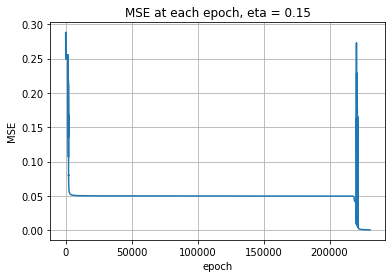

Training NN using eta = 0.1
  epoch 1000/1000000, MSE: 0.07616782515164512, Max Error: 0.894311730953122
  epoch 1268/1000000, MSE: 0.06107409022812148, Max Error: 0.8608774509628585
  epoch 1610/1000000, MSE: 0.056178566095728896, Max Error: 0.8353343431202017
  epoch 2043/1000000, MSE: 0.053828031771794765, Max Error: 0.8224924102285103
  epoch 2592/1000000, MSE: 0.05250171083509916, Max Error: 0.8150421662778793
  epoch 3290/1000000, MSE: 0.05169426057664126, Max Error: 0.8104188266388409
  epoch 4175/1000000, MSE: 0.05118141737055841, Max Error: 0.8074210279719002
  epoch 5298/1000000, MSE: 0.05084316672830892, Max Error: 0.8053975211810199
  epoch 6723/1000000, MSE: 0.05061293030655606, Max Error: 0.8039874489617937
  epoch 8531/1000000, MSE: 0.05045199600421781, Max Error: 0.8029796691773781
  epoch 10826/1000000, MSE: 0.05033695644356006, Max Error: 0.8022445771964547
  epoch 13738/1000000, MSE: 0.05025328339726185, Max Error: 0.8017002318139085
  epoch 17433/1000000, MSE: 0.050

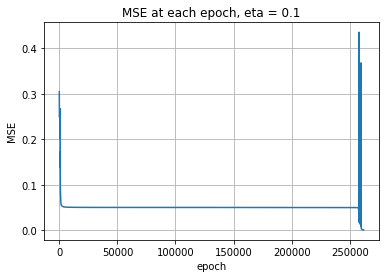

Training NN using eta = 0.05
  epoch 1000/1000000, MSE: 0.24987541220953224, Max Error: 0.5079577808183526
  epoch 1268/1000000, MSE: 0.24971845397244388, Max Error: 0.5128802405337457
  epoch 1610/1000000, MSE: 0.24828572084480977, Max Error: 0.5297545176291862
  epoch 2043/1000000, MSE: 0.08690508487579611, Max Error: 0.8028572296553187
  epoch 2592/1000000, MSE: 0.05583880958775395, Max Error: 0.8078083596750554
  epoch 3290/1000000, MSE: 0.04980340175281338, Max Error: 0.754563118220961
  epoch 4175/1000000, MSE: 0.046023922988001176, Max Error: 0.7092788845946872
  epoch 5298/1000000, MSE: 0.03700423563541127, Max Error: 0.5637093007783684
  epoch 6723/1000000, MSE: 0.03370689983297991, Max Error: 0.522197667396866
  epoch 8531/1000000, MSE: 0.03271303850441306, Max Error: 0.5118616501037789
  epoch 10826/1000000, MSE: 0.03221802193383021, Max Error: 0.5073942348849494
  epoch 13738/1000000, MSE: 0.0319251497811538, Max Error: 0.5049688171190668
  epoch 17433/1000000, MSE: 0.03173

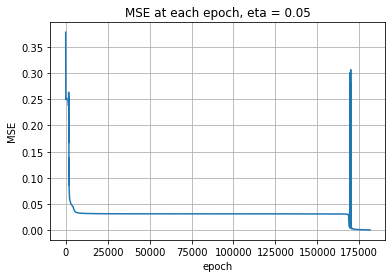

In [5]:
# Train NN for varying eta values
# With momentum (alpha=0.9)
for eta in [x/100 for x in range(50, 0, -5)]:
    print("Training NN using eta = {}".format(eta))   
    # Initialize NN
    shape = [4, 4, 1]
    weights = init(shape)
    all_mse = fit(weights, X, Y, eta, alpha=0.9, epochs=1000000)

    print("  Solution found after {} epochs".format(len(all_mse)))
    print("  Proof of solution:")
    for x,y in zip(X,Y):
        print(x, y, pred(weights, x))

    # Plot MSE
    x = np.arange(0, len(all_mse), 1)
    y = np.array(all_mse)
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel='epoch', ylabel='MSE',
       title='MSE at each epoch, eta = {}, alpha = 0.9'.format(eta))
    ax.grid()

    plt.show()

### Q1 Discussion
Based on the results above, $\eta = 0.1 + 0.1n$ corresponds to a faster-converging neural network, whereas $\eta = 0.05 + 0.1n$ is significantly slower (sometimes not even converging within 1,000,000 epochs). I'm not sure why this is the case, or that this trend even makes sense. Generally, I might expect the higher $\eta$ values to correspond to faster convergence rates. However, after running this code a handful of times, I have found that the rate of convergence is VERY dependant on the initial weights. 
Even with $\eta$ as low as $0.05$, I have had the NN converge in under 10K epochs when the initial weights were "good". But with "bad" initial weights, I have ended up waiting over 1 million epochs for convergence. 

I am not entirely sure what makes the initial weights "good" or "bad".
When the gradient descent process takes a long time, the NN seems to hang around MSE=0.25 or MSE=0.05.
I would guess this happens when the NN is taking a while get over a local "hump" that is caused by needing to negate one or two of the inputs. Maybe there is some smarter choice of initial weights than the suggested $-1 < w_{ij} < 1$, but I'm not aware of a better choice would be.

On average, including the momentum term, $\alpha=0.9$, speeds up training at each value of $\eta$. The NN converged within 1 million epochs for all 10 $\eta$ values. But again, this is still very dependent on getting "good"/"bad" initial weights.

Development of this code was a lengthy process for me. I started out trying to create classes for the layers and model. My original code can be found in the `q1_original.py` file. I had a lot of trouble getting this code to converge on the correct answer. The NN would converge on a model that outputted 0.5 for every input. There must be a small bug in the backpropagation code, but I cannot seem to find it. I ended up finding a [stackoverflow discussion](https://stackoverflow.com/questions/36369335/xor-neural-network-converges-to-0-5) where someone had a similar problem (with standard 2-bit XOR). This forum was very helpful to me in building my working NN. I took inspiration from the code presented in that discussion, and moved away from trying to build the NN using classes. The end result is successful and much simpler.

## References
* Course lecture slides
* This helped me figure out to convert numbers to a string with 4 bits: https://stackoverflow.com/questions/16926130/convert-to-binary-and-keep-leading-zeros-in-python
* Shuffling two lists, but keeping relative order: https://www.geeksforgeeks.org/python-shuffle-two-lists-with-same-order/
* Simple matplot https://matplotlib.org/stable/gallery/lines_bars_and_markers/simple_plot.html
* Fix to always predicting 0.5: https://stackoverflow.com/questions/36369335/xor-neural-network-converges-to-0-5
* Float range: https://stackoverflow.com/questions/7267226/range-for-floats
* Log-space evenly-spaced list: https://www.geeksforgeeks.org/how-to-create-a-list-of-uniformly-spaced-numbers-using-a-logarithmic-scale-with-python/
* Explanation of momentum in backpropagation
  * https://cs.stackexchange.com/questions/31874/how-does-the-momentum-term-for-backpropagation-algorithm-work
  * http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf